In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('.')

In [2]:
from copy import deepcopy

import numpy as np

from src.hmm import baum_welch as bw
from src.hmm.model import HMM
from src.hmm import visualization as vis
from src.hmm import viterbi as vit

**Resources**:
- [Forward+Viterbi] https://www.cis.upenn.edu/~cis262/notes/Example-Viterbi-DNA.pdf
- [Full intro to HMM + Forward + Viterbi] https://www.seas.upenn.edu/~cis262/notes/cis262-hmm.pdf
- [Intro to HMM + Forward + Viterbi + Forward-Backward] http://www.cs.tut.fi/kurssit/SGN-24006/PDF/L08-HMMs.pdf
- [Baum-Welch] https://en.wikipedia.org/wiki/Baum–Welch_algorithm
- [Baum-Welch implementation] http://www.adeveloperdiary.com/data-science/machine-learning/derivation-and-implementation-of-baum-welch-algorithm-for-hidden-markov-model/
- [Forward and backward implementations] http://www.adeveloperdiary.com/data-science/machine-learning/forward-and-backward-algorithm-in-hidden-markov-model/
- [Viterbi implementation] http://www.adeveloperdiary.com/data-science/machine-learning/implement-viterbi-algorithm-in-hidden-markov-model-using-python-and-r/

# Tasks
1. Implement **Forward** algorithm (function: `forward()` in file `src/hmm/forward_backward.py`)
2. Implement scoring function for given sequence of observations (function: `score_observation_sequence()` in file `src/hmm/forward_backward.py`)
3. Implement **Viterbi decoding** algorithm (function: `viterbi_decode()` in file `src/hmm/viterbi.py`)
4. Implement **Viterbi learning** algorithm (method `estimate_parameters()` in class `ViterbiTrainingAlgorithm` in file `src/hmm/viterbi.py`)
5. Implement **Backward** algorithm (function `backward()` in file `src/hmm/forward_backward.py`)
6. Implement **Baum-Welch** algorithm (method `estimate_parameters()` in class `BaumWelchAlgorithm` in file `src/hmm/baum_welch.py`)

In [3]:
def get_gene_hmm():
    _hmm = HMM(
        Z=('H', 'L'),
        X=('A', 'C', 'G', 'T'),
        init_dist={'H': 0.5, 'L': 0.5},
        transition_probs={
            ('H', 'H'): 0.5, ('H', 'L'): 0.5,
            ('L', 'L'): 0.6, ('L', 'H'): 0.4, 
        },
        emission_probs={
            ('A', 'H'): 0.2, ('C', 'H'): 0.3, ('G', 'H'): 0.3, ('T', 'H'): 0.2,
            ('A', 'L'): 0.3, ('C', 'L'): 0.2, ('G', 'L'): 0.2, ('T', 'L'): 0.3,
        }
    )

    return _hmm

# def get_weather_hmm():
#     _hmm = HMM(
#         Z=('Rainy', 'Sunny'),
#         X=('Walk', 'Shop', 'Clean'),
#         init_dist={'Rainy': 0.6, 'Sunny': 0.4},
#         transition_probs={
#             ('Rainy', 'Rainy'): 0.7, ('Rainy', 'Sunny'): 0.3,
#             ('Sunny', 'Rainy'): 0.4, ('Sunny', 'Sunny'): 0.6,
#         },
#         emission_probs={
#             ('Walk', 'Rainy'): 0.1, ('Shop', 'Rainy'): 0.4, ('Clean', 'Rainy'): 0.5,
#             ('Walk', 'Sunny'): 0.6, ('Shop', 'Sunny'): 0.3, ('Clean', 'Sunny'): 0.1,
#         }
#     )

#     return _hmm

# Define HMM
A **Hidden Markov Model** can be defined as a quintuple $(X, Z, \pi, a, b)$, where:
- $X$ - set of observations
- $Z$ - set of hidden states
- $\pi$ - initial state distribution; $\pi_i = P(z^1 = z_i)$ ($\pi_i$ denotes the probability of starting from state $z_i$)
- $a$ - transition probability matrix $a_{ij} = P(z^t = z_j | z^{t-1} = z_i)$ ($a_{ij}$ denotes the probability of moving from state $z_i$ to state $z_j$)
- $b$ - emission probability matrix $b_{jk} = P(x^t = x_k | z^t = z_j)$ ($b_{jk}$ denotes the probability of observing $x_k$ while being in state $z_j$)

The $t$ superscript denotes time step in the seqeuntial data.

In the below example we will use following parameters:
$$X = \{A, C, G, T\}$$

$$Z = \{H, L\}$$

$$\pi = [0.5, 0.5]$$

$$a = \begin{pmatrix} 0.5 & 0.5 \\ 0.4 & 0.6 \end{pmatrix}$$

$$b = \begin{pmatrix} 0.2 & 0.3 \\ 0.3 & 0.2 \\ 0.3 & 0.2 \\ 0.2 & 0.3\end{pmatrix}$$

![](assets/hmm/gene-hmm.png)
*Source: https://www.cis.upenn.edu/~cis262/notes/Example-Viterbi-DNA.pdf*

In [4]:
hmm = get_gene_hmm()
# hmm = get_weather_hmm()

vis.hmm_basic_info(hmm=hmm)

## Basic info for HMM

,"z_0 = ""H""","z_0 = ""L"""
P(z_0),0.5,0.5


,"z_t = ""H""","z_t = ""L"""
"z_t_1 = ""H""",0.5,0.5
"z_t_1 = ""L""",0.4,0.6


,"z_t = ""H""","z_t = ""L"""
"x_t = ""A""",0.2,0.3
"x_t = ""C""",0.3,0.2
"x_t = ""G""",0.3,0.2
"x_t = ""T""",0.2,0.3


# Probability of observing given sequence
To calculate the probability of observing a sequence $X$ given model parameters $\theta$ we use the so-called **Forward** algorithm. We start at the first observed value $x_1$ and compute its probabilities in all possible hidden states $z_1$ (probability of being in this state times the emission probability). For any other observation $x_t$, we do similar computations, but assuming that previously, we could have been in any hidden state $x_{t-1}$. Hence, we need to multiply the prob. of the previous state times the transition of the previous to current state and times the emission of the current observation. We sum such probabilities for all previous states. The matrix of all such probabilites is denoted by $\alpha$

$$\alpha = \forall_{z_j \in Z} \forall_{t \in \{1..T\}} \alpha_j(t)$$

$$
 \alpha_j(t) = 
  \begin{cases} 
   \pi_j b_{jk} & \text{if } t = 1 \\
   b_{jk} \sum_{z_i \in Z} \alpha_i(t - 1) a_{ij} & \text{if } t > 1
  \end{cases}
$$

To finally compute the probability of observing the given sequence $X$ we add the results in the last column of the $\alpha$ matrix:

$$\mathbb{P}(x_1, \ldots, x_T |\theta) = \sum_{z_i \in Z} \alpha_i(T)$$

![](assets/hmm/forward.png)

*Source: https://www.cis.upenn.edu/~cis262/notes/Example-Viterbi-DNA.pdf*

In [5]:
sample_X = ['G', 'G', 'C', 'A']
# sample_X = ['Walk', 'Clean', 'Clean', 'Clean', 'Shop']

log_p, alpha = hmm.predict_proba(sample_X, return_scores=True)
print(f'Log-Probability of observing X: {log_p} (actual probability: {np.exp(log_p)})')

vis.print_table(scores=alpha, T=len(sample_X), Z=hmm.Z, name='Forward')

Log-Probability of observing X: -5.561462936154914 (actual probability: 0.003843149999999999)


## Forward table

,t = 0,t = 1,t = 2,t = 3
"z = ""H""",-1.8971,-3.3668,-4.7777,-6.5881
"z = ""L""",-2.3026,-3.6119,-5.0071,-6.005


# Most probable hidden state sequence for given observations
Another problem is to find the most probable sequence of hidden states $Z_{max}$ for a given sequence of observations $X$. 

$$Z_{max} = \max_{z^1, \ldots, z^T} \mathbb{P}(z^1,z^2,\ldots,z^T, x^1,x^2, \ldots, x^T | \theta)$$

We employ the **Viterbi decoding** algorithm, which uses a similar scheme like in the **Forward** algorithm, but instead of computing the sum over all previous states, it chooses the state that had the higest probability.


$$\omega_i(t) = \max_{z^1, \ldots, z^t} \mathbb{P}(z^1, \ldots, z^{t-1}, \mathbf{z^t = z_i}, x^1, \ldots, x^{t-1}, x^t | \theta)$$

$$
 \omega_j(t) = 
  \begin{cases} 
   \pi_j b_{jk} & \text{if } t = 1 \\
   b_{jk} \max_{z_i \in Z}  a_{ij} \omega_i(t - 1) & \text{if } t > 1
  \end{cases}
$$ 

While computing these values, we should mark which of the previous states had the highest probability. We can then use those to retrieve the most probable path (*backtracking*)

![](assets/hmm/viterbi-decoding.png)

*Source: https://www.cis.upenn.edu/~cis262/notes/Example-Viterbi-DNA.pdf*

In [6]:
max_Z, scores = hmm.predict(sample_X, return_scores=True)
print('Most probable sequence of hidden states:', max_Z)

vis.print_viterbi_table(scores=scores, T=len(sample_X), Z=hmm.Z)

Most probable sequence of hidden states: ['H', 'H', 'H', 'L']


## Viterbi table

,t = 0,t = 1,t = 2,t = 3
"z = ""H""","(-2.737, 0.15)","(-5.4739, 0.0225)","(-8.2109, 0.003375)","(-11.5328, 0.0003375)"
"z = ""L""","(-3.3219, 0.1)","(-6.0589, 0.015)","(-8.7959, 0.00225)","(-10.9479, 0.00050625)"


# Generate data from HMM

In [7]:
num_observations = 10
X_generated, Z_generated = hmm.generate(N=num_observations)

print('Generated sequences')
print('Z (hidden states):', Z_generated)
print('X (observations):', X_generated)

Generated sequences
Z (hidden states): ['H', 'L', 'L', 'H', 'H', 'L', 'L', 'H', 'L', 'H']
X (observations): ['G', 'C', 'C', 'G', 'C', 'G', 'G', 'G', 'A', 'T']


# Training of HMM

In [8]:
def make_dataset(model, num_seq, seq_length, train_size):
    tr_size = int(train_size * num_seq)
    te_size = num_seq - tr_size

    ds = {
        'train': np.array([model.generate(N=seq_length)[0] for _ in range(tr_size)]),
        'test': np.array([model.generate(N=seq_length)[0] for _ in range(te_size)]),
    }
    
    return ds

In [9]:
def pdist(n):
    p = np.random.uniform(size=n)
    p /= sum(p)
    return p


def get_uninitialized_hmm(Z, X):
    # Initial distribution    
    pi = {z: v for z, v in zip(Z, pdist(len(Z)))}
    
    # Transition probs
    tr = {
        (z_t_1, z_t): p
        for z_t_1 in Z
        for z_t, p in zip(Z, pdist(len(Z)))
    }
    
    # Emission probs
    em = {
        (x, z_k): p
        for z_k in Z
        for x, p in zip(X, pdist(len(X)))
    }
    
    _hmm = HMM(Z=Z, X=X, init_dist=pi, transition_probs=tr, emission_probs=em)
    return _hmm


def get_uninitialized_gene_hmm():
    return get_uninitialized_hmm(
        Z=('H', 'L'),
        X=('A', 'C', 'G', 'T'),
    )


def get_uninitialized_weather_hmm():
    return get_uninitialized_hmm(
        Z=('Rainy', 'Sunny'),
        X=('Walk', 'Shop', 'Clean'),
    )

In [10]:
dataset = make_dataset(model=hmm, num_seq=1_000, seq_length=10, train_size=0.8)

print('Train =>', dataset['train'].shape)
print('Test =>', dataset['test'].shape)

Train => (800, 10)
Test => (200, 10)


# Viterbi learning
This algorithm is an example of using the Maximum Likelihood Estimation to obtain the model's parameters. It is defined as follows:
1. Start from random initial parameters $\theta_0$
2. While stopping criterion is not fulfilled:
    - initiate starting counts $n_\pi$, transition counts $n_a$, emission counts $n_b$
    - for every observation $x \in X_{train}$:
        - get most probable path $Z_{max}$ for $x$ (using Viterbi decoding algorithm)
        - update $n_\pi$, $n_a$, $n_b$ using $Z_{max}$ and $x$
    - compute $\theta = (\pi, a, b)$ by normalizing the counts $n_\pi$, $n_a$, $n_b$
    
    $$\pi_i = \frac{n_{\pi_i}}{\sum_{j \in |Z|} n_{\pi_j}}$$
    
    $$a_{ij} = \frac{n_{a_{ij}}}{\sum_{j \in |Z|} n_{a_{ij}}}$$

    $$b_{jk} = \frac{n_{b_{jk}}}{\sum_{k \in |X|} n_{b_{jk}}}$$
3. Return model with parameters $\theta$


As the stopping critertion we will use 2 conditions (stop if any is not fulfilled):
- maximum number of iterations (epochs);  
$$i < max\_epochs$$
- change in parameter values if smaller that a threshold; 
$$(\theta_{i+1} - \theta_i)^2 > \epsilon$$

In [11]:
random_hmm = get_uninitialized_gene_hmm()
# random_hmm= get_uninitialized_weather_hmm()

vis.hmm_basic_info(random_hmm)

## Basic info for HMM

,"z_0 = ""H""","z_0 = ""L"""
P(z_0),0.0617312,0.938269


,"z_t = ""H""","z_t = ""L"""
"z_t_1 = ""H""",0.485192,0.514808
"z_t_1 = ""L""",0.254383,0.745617


,"z_t = ""H""","z_t = ""L"""
"x_t = ""A""",0.260466,0.0614088
"x_t = ""C""",0.221247,0.120497
"x_t = ""G""",0.331494,0.312904
"x_t = ""T""",0.186793,0.50519


Epoch: 0 => Loss: 0.40945, Log-prob: -13.840729073982192
Epoch: 1 => Loss: 0.02171, Log-prob: -13.844866086313438
Epoch: 2 => Loss: 0.16357, Log-prob: -13.871739373552687
Epoch: 3 => Loss: 0.0, Log-prob: -13.871739373552687



## Basic info for HMM

,"z_0 = ""H""","z_0 = ""L"""
P(z_0),0.00124688,0.998753


,"z_t = ""H""","z_t = ""L"""
"z_t_1 = ""H""",0.253503,0.746497
"z_t_1 = ""L""",0.245119,0.754881


,"z_t = ""H""","z_t = ""L"""
"x_t = ""A""",0.998316,0.0334029
"x_t = ""C""",0.000561482,0.319897
"x_t = ""G""",0.000561482,0.318131
"x_t = ""T""",0.000561482,0.328569


Test log-p: -13.868452829489119


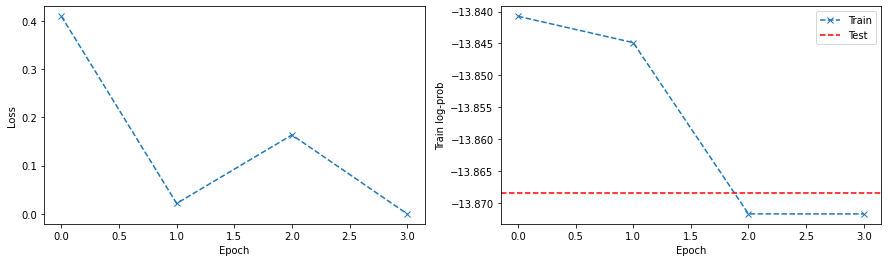

In [12]:
hmm_viterbi = deepcopy(random_hmm)
logs = hmm_viterbi.fit(X=dataset['train'], algorithm='viterbi')
vis.hmm_basic_info(hmm_viterbi)
vis.training_plots(hmm_viterbi, logs['losses'], logs['probas'], dataset['test'])

# Forward-backward (Baum-Welch)
Before we explain the Baum-Welch algorithm, we need to introduce the **Backward** algorithm. It can be seen as a symmetrical (in time) version of the **Forward** algorithm. At a given moment $t$, we want to estimate the probability of observing symbols $x^{t+1}, \ldots, x^T$ while being in state $z^t = z_i$.

$$\beta_i(t) = \mathbb{P}(x^{t+1}, \ldots, x^T|z^t = z_i)$$

We compute a matrix $\beta$, where:

$$\beta = \forall_{z_i \in Z} \forall_{t \in \{1..T\}} \beta_i(t)$$

$$
 \beta_i(t) =
  \begin{cases}
   1 & \text{if } t = T \\
   \sum_{z_j \in Z} a_{ij} b_{jk_{t+1}} \beta_j(t + 1)    & \text{if } t < T
  \end{cases}
$$


Using both algorithms we can define the **Forward-backward** (aka **Baum-Welch**) algorithm:
1. Start from random initial parameters $\theta_0$
2. While stopping criterion is not fulfilled:
    - for every observation $x^{(r)} \in X_{train}$, where $r \in R$ and $R = |X_{train}|$:
        - compute $\alpha^{(r)}$ and $\beta^{(r)}$ for observations $x^{(r)}$
        - perform expectation step: compute $\xi^{(r)}$ and $\gamma^{(r)}$ for current parameters $\theta$
        
        $$\gamma^{(r)}_{i}(t) = \frac{\alpha^{(r)}_i(t)\beta^{(r)}_i(t)}{\sum_{z_j \in Z} \alpha^{(r)}_j(t)\beta^{(r)}_j(t)}$$
        
        $$\xi_{ij}^{(r)}(t) = \frac{\alpha_i^{(r)}(t)a_{ij}\beta_j^{(r)}(t + 1)b_{jk_{t+1}}^{(r)}}{\sum_{z_u \in Z} \sum_{z_v \in Z} \alpha_u^{(r)}(t)a_{uv}\beta_v^{(r)}(t + 1)b_{vk_{t+1}}^{(r)}}  $$
        
        - perform maximization step: compute new parameters $\theta$ using $\xi$ and $\gamma$
        
        $$\pi_i = \frac{\sum_{r = 1}^R \gamma_i^{(r)}(1)}{R}$$
        
        $$a_{ij} = \frac{\sum_{r = 1}^R \sum_{t = 1}^{T-1} \xi_{ij}^{(r)}(t)}{\sum_{r = 1}^R \sum_{t = 1}^{T-1} \gamma_i^{(r)}(t)}$$
        
        $$b_{jk} = \frac{\sum_{r = 1}^R \sum_{t = 1}^T \gamma_j^{(r)}(t) \mathbb{1}_{x_{t}^{(r)} = x_k}}{\sum_{r = 1}^R \sum_{t = 1}^T \gamma_j^{(r)}(t)}$$
3. Return model with parameters $\theta$

In [13]:
hmm_bw = deepcopy(random_hmm)
logs = hmm_bw.fit(X=dataset['train'], algorithm='baum-welch')

vis.hmm_basic_info(hmm_bw)
vis.training_plots(hmm_bw, logs['losses'], logs['probas'], dataset['test'])

NotImplementedError: 

In [22]:
from src.hmm.forward_backward import backward

init_dist={'H': 0.5, 'L': 0.5}
transition_probs={
    ('H', 'H'): 0.5, ('H', 'L'): 0.5,
    ('L', 'L'): 0.6, ('L', 'H'): 0.4,
}
emission_probs={
    ('A', 'H'): 0.2, ('C', 'H'): 0.3, ('G', 'H'): 0.3, ('T', 'H'): 0.2,
    ('A', 'L'): 0.3, ('C', 'L'): 0.2, ('G', 'L'): 0.2, ('T', 'L'): 0.3,
}
backward((init_dist, transition_probs,emission_probs),sample_X)

{(3, 'H'): 0.0,
 (3, 'L'): 0.0,
 (2, 'H'): -1.3862943611198906,
 (2, 'L'): -1.3470736479666092,
 (1, 'H'): -2.756715373083491,
 (1, 'L'): -2.7936080894638566,
 (0, 'H'): -4.157603901861291,
 (0, 'L'): -4.202107962496237}

In [ ]:
from src.hmm.forward_backward import backward

init_dist={'H': 0.5, 'L': 0.5}
transition_probs={
    ('H', 'H'): 0.5, ('H', 'L'): 0.5,
    ('L', 'L'): 0.6, ('L', 'H'): 0.4,
}
emission_probs={
    ('A', 'H'): 0.2, ('C', 'H'): 0.3, ('G', 'H'): 0.3, ('T', 'H'): 0.2,
    ('A', 'L'): 0.3, ('C', 'L'): 0.2, ('G', 'L'): 0.2, ('T', 'L'): 0.3,
}
backward((init_dist, transition_probs,emission_probs),sample_X)